# Word2Vec

In [1]:
%matplotlib inline
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import bz2
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import nltk # standard preprocessing
import operator # sorting items in dictionary by value
#nltk.download() #tokenizers/punkt/PY3/english.pickle
from math import ceil
import csv

D:\anaconda\anaconda\envs\tf18\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\anaconda\envs\tf18\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\anaconda\envs\tf18\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\anaconda\envs\tf18\lib\site-packages\tensorflow\python\framework\dtypes.py:5

# 1 数据集准备

In [2]:
url = 'http://www.evanjones.ca/software/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        print('Downloading file...')
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('wikipedia2text-extracted.txt.bz2', 18377035)

Found and verified wikipedia2text-extracted.txt.bz2


# 2 读取数据但是不做预处理

这一步是做读取数据与分词处理

有一千多万个数据，所以运行速度较慢

In [3]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""

    with bz2.BZ2File(filename) as f:
        data = []
        file_string = f.read().decode('utf-8')
        file_string = nltk.word_tokenize(file_string)
        data.extend(file_string)
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))
print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])

Data size 11634727
Example words (start):  ['Propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Example words (end):  ['useless', 'for', 'cultivation', '.', 'and', 'people', 'have', 'sex', 'there', '.']


# 3 读取数据并做预处理

这一步是做读取数据，并做预处理

预处理也就是将所有的单词换为小写，并且以1M的大小来进行数据读取

读取后再用nltk进行分词处理

In [4]:
def read_data(filename):
    """
    Extract the first file enclosed in a zip file as a list of words
    and pre-processes it using the nltk python library
    """

    with bz2.BZ2File(filename) as f:

        data = []
        file_size = os.stat(filename).st_size
        chunk_size = 1024 * 1024 # reading 1 MB at a time as the dataset is moderately large
        print('Reading data...')
        for i in range(ceil(file_size//chunk_size)+1):
            bytes_to_read = min(chunk_size,file_size-(i*chunk_size))
            file_string = f.read(bytes_to_read).decode('utf-8')
            file_string = file_string.lower()
            # tokenizes a string to words residing in a list
            file_string = nltk.word_tokenize(file_string)
            data.extend(file_string)
    return data

words = read_data(filename)
print('Data size %d' % len(words))
print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])

Reading data...
Data size 3361192
Example words (start):  ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Example words (end):  ['favorable', 'long-term', 'outcomes', 'for', 'around', 'half', 'of', 'those', 'diagnosed', 'with']


# 4 创建词典

根据以下的规则进行词典的创建. 为了方便理解以下的元素，采用 "I like to go to school"作为例子.

* `dictionary`: 词语与ID之间的映射关系 (e.g. {I:0, like:1, to:2, go:3, school:4})
* `reverse_dictionary`: ID与词语之间的映射关系 (e.g. {0:I, 1:like, 2:to, 3:go, 4:school})
* `count`: 列表，列表中每个元素是个元组，每个元组中的元素为单词以及频率 (word, frequency) (e.g. [(I,1),(like,1),(to,2),(go,1),(school,1)])
* `data` : 文本中的词语，这些词语以ID来代替 (e.g. [0, 1, 2, 3, 2, 4])

标记 `UNK` 来表示稀有词语。

In [5]:
# we restrict our vocabulary size to 50000
vocabulary_size = 50000 

def build_dataset(words):
    count = [['UNK', -1]]  # 因为后面还需要更改这个-1的值，所以这里是列表
    # Gets only the vocabulary_size most common words as the vocabulary
    # All the other words will be replaced with UNK token
    # 就是说提取50000个最常见的单词，其余全部归类为'UNK'
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()

    # Create an ID for each word by giving the current length of the dictionary
    # And adding that item to the dictionary
    # word: 单词名, _: 出现的次数(频率)
    # 这一步是做词语与id的映射
    # dictionary: {'word1': 0, 'word2': 1, 'word3': 2, ...}
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0  # 记录有多少个unk
    # Traverse through all the text we have and produce a list
    # where each element corresponds to the ID of the word found at that index
    # 如果词语在dictionary中，则用该词语的id
    # 否则则是UNK，id为0(因为dictionary中第1个单词也是UNK)
    for word in words:
        # If word is in the dictionary use the word ID,
        # else use the ID of the special token "UNK"
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    
    # update the count variable with the number of UNK occurences
    # 更新count，其实就是更新UNK的数量
    count[0][1] = unk_count
  
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    # Make sure the dictionary is of size of the vocabulary
    assert len(dictionary) == vocabulary_size
    
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 68751], ('the', 226893), (',', 184013), ('.', 120919), ('of', 116323)]
Sample data [1721, 9, 8, 16479, 223, 4, 5168, 4459, 26, 11597]


# 5 定义Skip-gram的batch

Generates a batch or target words (`batch`) and a batch of corresponding context words (`labels`). It reads `2*window_size+1` words at a time (called a `span`) and create `2*window_size` datapoints in a single span. The function continue in this manner until `batch_size` datapoints are created. Everytime we reach the end of the word sequence, we start from beginning. 

就是说每一批次中都有一个`batch`，这个`batch`是目标词，`labels`是这个目标词的上下文。每一个`span`读取`2 * window_size + 1`个词语(窗口大小 + 目标词)，同时定义上下文大小为`2 * window_size`。该方法会执行到`batch_size`这么多数据创建。每当循环到这个词语序列的最后，就会重新开始。

因为是Skip-gram模型，所以会提取出这个词语的上下文内容。

In [6]:
data_index = 0

def generate_batch_skip_gram(batch_size, window_size):
    # data_index is updated by 1 everytime we read a data point
    # 调用外部的变量
    global data_index 
    # print('global data_index:', data_index)
    # print('batch_size:', batch_size)
    # print('window_size:', window_size)
    
    # two numpy arras to hold target words (batch)
    # and context words (labels)
    # batch: 随机初始大小为 batch_size × 1 的向量
    # labels: 随机初始大小为 1 × batch_size 的向量
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # span defines the total window size, where
    # data we consider at an instance looks as follows. 
    # [ skip_window target skip_window ]
    # span: 2 * 窗口大小 + 1, i.e. 左右上下文 + 目标词
    span = 2 * window_size + 1 
    
    # The buffer holds the data contained within the span
    # deque创建的队列可以从左从右加入数据
    buffer = collections.deque(maxlen=span)
  
    # Fill the buffer and update the data_index
    # 将ID添加到buffer中
    # 该循环运行完后，data_index会移动到窗口后一位
    # e.g. window_size = 2, span = 5, 循环结束后 data_index = 5
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # print('data_index: ', data_index)
    # print('buffer before loop:', buffer)
    
    # This is the number of context words we sample for a single target word
    # 上下文的大小
    num_samples = 2*window_size 

    # We break the batch reading into two for loops
    # The inner for loop fills in the batch and labels with 
    # num_samples data points using data contained within the span
    # The outper for loop repeat this for batch_size//num_samples times
    # to produce a full batch
    # 假设窗口大小为2
    # range(batch_size // num_samples): 0, 1
    for i in range(batch_size // num_samples):
        k=0
        # avoid the target word itself as a prediction
        # fill in batch and label numpy arrays
        # 假设窗口大小为2
        # list(range(window_size)): [0, 1]
        # list(range(window_size + 1, 2 * window_size + 1)): [3, 4]
        # j 的循环范围: [0, 1, 3, 4], 避开了2,, 也就是目标词汇
        for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
            batch[i * num_samples + k] = buffer[window_size]
            labels[i * num_samples + k, 0] = buffer[j]
            k += 1 
    
        # Everytime we read num_samples data points,
        # we have created the maximum number of datapoints possible
        # withing a single span, so we need to move the span by 1
        # to create a fresh new span
        # 由于buffer的maxlen只有窗口 + 1的大小
        # 所以这里append一个新的元素会使得第一个元素出队
        # 就可以使得窗口向右滑动一格
        buffer.append(data[data_index])
        # print('buffer after change:', buffer)
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for window_size in [1, 2]:
    data_index = 0
    # batch: 目标词汇
    # labels: 上下文单词
    # batch中目标词汇对应的索引在labels中就是该词汇的上下文
    batch, labels = generate_batch_skip_gram(batch_size=8, window_size=window_size)
    print('\nwith window_size = %d:' %window_size)
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed']

with window_size = 1:
    batch: ['is', 'is', 'a', 'a', 'concerted', 'concerted', 'set', 'set']
    labels: ['propaganda', 'a', 'is', 'concerted', 'a', 'set', 'concerted', 'of']

with window_size = 2:
    batch: ['a', 'a', 'a', 'a', 'concerted', 'concerted', 'concerted', 'concerted']
    labels: ['propaganda', 'is', 'concerted', 'set', 'is', 'a', 'set', 'of']


# 6 Skip-gram

## 6.1 定义超参数

`batch_size`： 一个batch中的样本数 

`embedding_size`：嵌入向量的大小(隐藏层神经元个数)

`window_size`： 上下文大小

In [7]:
batch_size = 128 # Data points in a single batch
embedding_size = 128 # Dimension of the embedding vector.
window_size = 4 # How many words to consider left and right.

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 50

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)

num_sampled = 32 # Number of negative examples to sample.

`random.sample`: 截取列表指定长度的随机数，但是不会改变列表本身的排序

## 6.2 定义输入与输出的占位符

为每一个batch定义输入与输出的占位符。

还定义了一个验证集的常数。

In [8]:
tf.reset_default_graph()

# Training input data (target word IDs).
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# Validation input data, we don't need a placeholder
# as we have already defined the IDs of the words selected
# as validation data
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

## 6.3 定义模型参数与其他变量

In [9]:
# Variables

# Embedding layer, contains the word embeddings
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# Softmax Weights and Biases
softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=0.5 / math.sqrt(embedding_size))
)
softmax_biases = tf.Variable(tf.random_uniform([vocabulary_size],0.0,0.01))

`truncated_normal`： 截断的产生正态分布的随机数，即随机数与均值的差值若大于两倍的标准差，则重新生成。

`embeddings`: $W$, 输入层到隐藏层的权重矩阵, $50000 \times 128$的张量，均匀分布在$[-1, 1]$

`softmax_weights`: $W'$, 隐藏层到输出层的权重矩阵, $50000 \times 128$的张量, 截断正态分布, 均值为0(默认值)，标准差为$\frac{0.5}{\sqrt{128}}$

`softmax_biases`: $b$, 输出层的偏置向量，$50000 \times 1$，均匀分布在$[0, 0.01]$

## 6.4 定义模型计算

首先定义了一个查询方法来获得嵌入向量与给定输入之间的关系(`embedding_lookup`). 同时定义了负采样的损失函数`tf.nn.sampled_softmax_loss`, 该函数采用的是之前定义的参数.

In [10]:
# Model.
# Look up embeddings for a batch of inputs.
embed = tf.nn.embedding_lookup(embeddings, train_dataset)

# Compute the softmax loss, using a sample of the negative labels each time.
# 计算的是平均损失
loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(
        weights=softmax_weights, biases=softmax_biases, inputs=embed,
        labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size)
)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



`tf.nn.embedding_lookup(params, ids)`: 按照ids从params这个矩阵中拿向量（行）, `params`是输入的张量, `ids`是张量对应的索引

sampled_softmax_loss(weights, biases, labels, inputs, num_sampled, num_classed, num_true=1, sampled_values=None, remove_accidental_hits=True, partition_strategy='mod', name='sampled_softmax_loss'):

`weights`:     神经网络输出层权重, `shape`: [num_classes, dim]

`biases`:      神经网络输出层偏置, `shape`: [num_classes]

`labels`:      输出层标签

`inputs`:      输出层的输入

`num_sampled`: 采样个数

`num_classes`: 分类个数

`num_true`:    在负采样softmax中的实际分类（正负），默认为1即二分类

这里将`embed`作为inputs，是因为Word2Vec的输入层是one-hot，即$W$就是之前的输入。

## 6.5 计算词语相似度

采用余弦相似度计算两个词语的相似度(minibatch和所有嵌入向量)

In [11]:
# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

`余弦相似度`: ${\rm cos}\theta = \frac{\vec{A} · \vec{B}}{|\vec{A}|\times |\vec{B}|}$

`tf.square()`: 对每个元素求平方

`reduce_sum(tensor, 1, keepdims=True)`: 按照每一行对元素进行求和

`TensorFlow中矩阵除向量`: 矩阵$A$是$N \times M$, 向量$v$必须是$N \times 1$，其计算就是$A$中第$i$行的所有元素除以$v$中$i$行的元素。

`norm`: 每一行元素平方和求和后，对每行(因为每行只有一个元素)求平方根(向量的模，即分母), $50000\times 1$

`normalized_embeddings`: L2正则化的矩阵，embedding的每一行元素除以这一行的模，保证这一行的模为1

`valid_embeddings`： 提取normalized_embeddings中验证集里的数据

`similarity`： 由于经过了L2正则化，所以模为1，于是余弦相似度就等同于矩阵乘法。valid_embeddings中每一行代表了一个词语的向量，所以要对normalized_embeddings进行转置，才能够实现矩阵乘法。

## 6.6 优化器

采用adagrad优化器，学习率为1.0

Adagrad是解决不同参数应该使用不同的更新速率的问题。Adagrad自适应地为各个参数分配不同学习率的算法。

In [12]:
# Optimizer.
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

## 6.7 运行Skip-gram

`tf.ConfigProto`: 配置session，`allow_soft_placement=True`: 当运行设备不满足要求时，会自动分配GPU或者CPU。

`tf.Tensor.eval`: 类似于session.run()，只不过session.run()可以同一步获取多个计算结果。

`argsort()`: 将元素从小到大排序。

In [13]:
num_steps = 100001
skip_losses = []
# ConfigProto is a way of providing various configuration settings 
# required to execute the graph
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
    # Initialize the variables in the graph
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0

    # Train the Word2vec model for num_step iterations
    for step in range(num_steps):

        # Generate a single batch of data
        batch_data, batch_labels = generate_batch_skip_gram(
            batch_size, window_size)

        # Populate the feed_dict and run the optimizer (minimize loss)
        # and compute the loss
        # _: 占位符，调用优化函数
        # l: 损失
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        # Update the average loss variable
        average_loss += l
        
        # 每2000步计算一次平均损失的平均
        if (step + 1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000

            skip_losses.append(average_loss)
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step + 1, average_loss))
            average_loss = 0

        # Evaluating validation set word similarities
        if (step + 1) % 10000 == 0:
            sim = similarity.eval()
            # Here we compute the top_k closest words for a given validation word
            # in terms of the cosine distance
            # We do this for all the words in the validation set
            # Note: This is an expensive step
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]  # 提取出验证集中的词语
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]  # 相似度按照从大到小排序
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    skip_gram_final_embeddings = normalized_embeddings.eval()
    
# We will save the word vectors learned and the loss over time
# as this information is required later for comparisons
np.save('skip_embeddings',skip_gram_final_embeddings)

with open('skip_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(skip_losses)

Initialized
Average loss at step 2000: 3.994010
Average loss at step 4000: 3.633656
Average loss at step 6000: 3.589121
Average loss at step 8000: 3.517174
Average loss at step 10000: 3.493418
Nearest to which: caesar, transshipment, and, ganon, homophonic, eligible, ., post-traumatic,
Nearest to of: dharmic, ., caesar, lasting, surpass, vineyard, amniotic, composition,
Nearest to 's: threats, renovation, the, paisiello, plesiosaur, polymers, shamanistic, 10.2,
Nearest to and: ,, ., bechuanaland, regular, which, renal, contend, in,
Nearest to has: is, have, huambo, bennington, unstudied, hyperkalemia, ovaries, nato,
Nearest to was: is, tallaght, sharapova, the, subversion, gymnasium, ely, fascism,
Nearest to one: lice, trinidadian, fonda, 1586, moderates, jurisdictional, gritty, army,
Nearest to .: ,, malls, and, demand, of, hadrons, precise, in,
Nearest to the: a, italia, immunity, was, 's, parkwide, infancy, broad,
Nearest to not: presiding, qassim, tommaso, istum, iranians, prolonge

## 6.8 可视化skip-gram学习过程

### 6.8.1 仅查找聚类的单词而非稀疏分布的单词

In [14]:
def find_clustered_embeddings(embeddings,distance_threshold,sample_threshold):
    ''' 
    Find only the closely clustered embeddings. 
    This gets rid of more sparsly distributed word embeddings and make the visualization clearer
    This is useful for t-SNE visualization
    
    distance_threshold: maximum distance between two points to qualify as neighbors
    sample_threshold: number of neighbors required to be considered a cluster
    '''
    
    # calculate cosine similarity
    cosine_sim = np.dot(embeddings,np.transpose(embeddings))
    norm = np.dot(np.sum(embeddings**2,axis=1).reshape(-1,1),np.sum(np.transpose(embeddings)**2,axis=0).reshape(1,-1))
    assert cosine_sim.shape == norm.shape
    cosine_sim /= norm  # 求得余弦相似度
    
    # make all the diagonal entries zero otherwise this will be picked as highest
    # 在这里对角线元素就是词语 i 的向量与自己的点积
    # 就是说不考虑自己与自己的相似度(因为自己与自己的相似度是最高的)
    np.fill_diagonal(cosine_sim, -1.0)  # 将cosine_sim的对角线元素变为-1
    
    argmax_cos_sim = np.argmax(cosine_sim, axis=1)
    mod_cos_sim = cosine_sim
    # find the maximums in a loop to count if there are more than n items above threshold
    # 将每一行的最大值设置为-1
    for _ in range(sample_threshold-1):
        argmax_cos_sim = np.argmax(cosine_sim, axis=1)  # 每一轮迭代选一个最大值出来
        mod_cos_sim[np.arange(mod_cos_sim.shape[0]),argmax_cos_sim] = -1  # 将这轮迭代选出的最大值设置为-1
    
    max_cosine_sim = np.max(mod_cos_sim,axis=1)  # 迭代完成后选择出当前矩阵中的最大元素

    return np.where(max_cosine_sim>distance_threshold)[0]

`cosine_sim`: $50000 \times 128 * 128 \times 50000 = 50000 \times 50000$，每两个词语之间的点积。

`norm`: $50000 \times 1 * 1 \times 50000 = 50000 \times 50000$，每一行元素平方和求和再点积转置后每一列元素平方和求和。

`np.argmax(ndarray, axis=1)`: 求每一行向量中最大元素的索引。

函数返回的是满足条件的元素的下标。

### 6.8.2 采用sklearn计算词嵌入的t-SNE可视化

In [18]:
num_points = 1000 # we will use a large sample space to build the T-SNE manifold and then prune it using cosine similarity

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

print('Fitting embeddings to T-SNE. This can take some time ...')
# get the T-SNE manifold
selected_embeddings = skip_gram_final_embeddings[:num_points, :]  # 提取前1000个嵌入向量
two_d_embeddings = tsne.fit_transform(selected_embeddings)

print('Pruning the T-SNE embeddings')
# prune the embeddings by getting ones only more than n-many sample above the similarity threshold
# this unclutters the visualization
selected_ids = find_clustered_embeddings(selected_embeddings,.25,10)  # 获得聚类单词的id
two_d_embeddings = two_d_embeddings[selected_ids,:]

print('Out of ',num_points,' samples, ', selected_ids.shape[0],' samples were selected by pruning')

Fitting embeddings to T-SNE. This can take some time ...
Pruning the T-SNE embeddings
Out of  1000  samples,  362  samples were selected by pruning


`TSNE`: `perplexity`: 困惑度，与最近邻居相关; `n_components`: 嵌入空间大小; `init='pca'`: 初始化嵌入，采用PCA降维方式; `n_iter`: 优化的最高迭代次数; `fit_transform`: fit和transform的结合，训练后进行降维操作。

### 6.8.3 采用Matplotlib绘制t-SNE的图

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

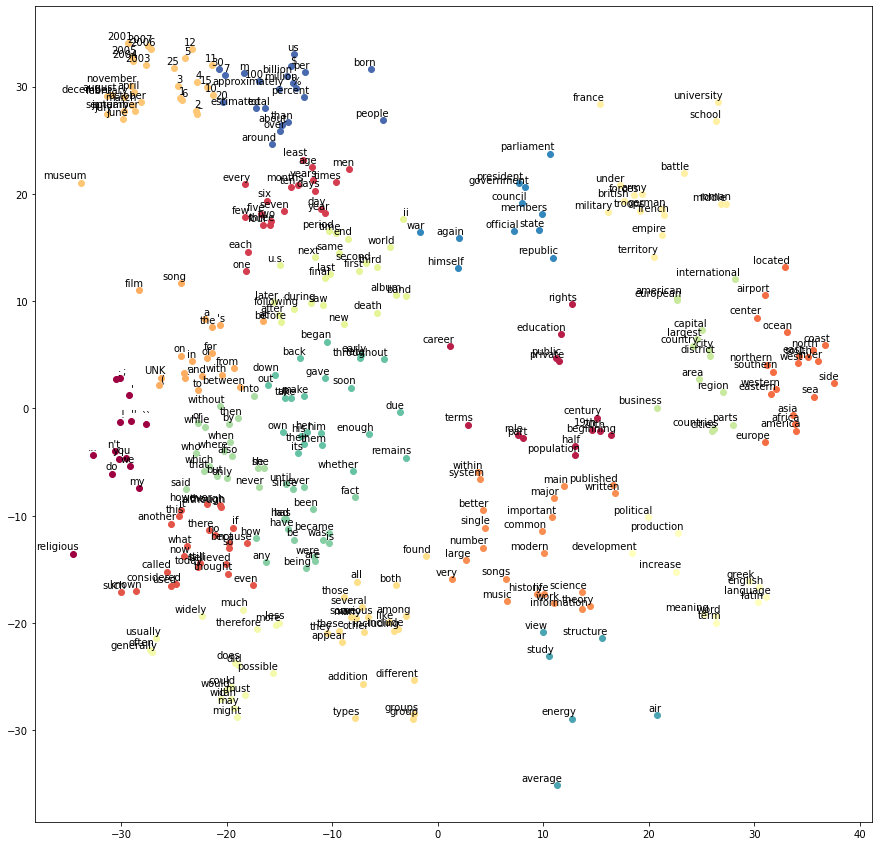

In [20]:
def plot(embeddings, labels):
  
    n_clusters = 20 # number of clusters
    # automatically build a discrete set of colors, each for cluster
    label_colors = [pylab.cm.Spectral(float(i) /n_clusters) for i in range(n_clusters)]
  
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  
    # Define K-Means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(embeddings)
    kmeans_labels = kmeans.labels_
  
    pylab.figure(figsize=(15,15))  # in inches
    
    # plot all the embeddings and their corresponding words
    for i, (label,klabel) in enumerate(zip(labels,kmeans_labels)):
        x, y = embeddings[i,:]
        pylab.scatter(x, y, c=label_colors[klabel])    

        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom',fontsize=10)

    # use for saving the figure if needed
    #pylab.savefig('word_embeddings.png')
    pylab.show()

words = [reverse_dictionary[i] for i in selected_ids]
plot(two_d_embeddings, words)


# 7 CBOW

## 7.1 更改数据生成过程

输入向量的大小变为(batch_size, context_window *2).

In [22]:
data_index = 0

def generate_batch_cbow(batch_size, window_size):
    # window_size is the amount of words we're looking at from each side of a given word
    # creates a single batch
    # 输入是词语 i 的上下文，单侧上下文有 window_size 个单词
    
    # data_index is updated by 1 everytime we read a set of data point
    global data_index

    # span defines the total window size, where
    # data we consider at an instance looks as follows. 
    # [ skip_window target skip_window ]
    # e.g if skip_window = 2 then span = 5
    # 左右侧上下文单词 + 目标单词
    span = 2 * window_size + 1 # [ skip_window target skip_window ]

    # two numpy arras to hold target words (batch)
    # and context words (labels)
    # Note that batch has span-1=2*window_size columns
    # batch: 目标单词的上下文单词
    # labels: 目标单词
    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # The buffer holds the data contained within the span
    buffer = collections.deque(maxlen=span)

    # Fill the buffer and update the data_index
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # Here we do the batch reading
    # We iterate through each batch index
    # For each batch index, we iterate through span elements
    # to fill in the columns of batch array
    # i: 记录目标词语的索引
    for i in range(batch_size):
        target = window_size  # target label at the center of the buffer
        target_to_avoid = [ window_size ] # we only need to know the words around a given word, not the word itself

        # add selected target to avoid_list for next time
        col_idx = 0  # 记录上下文词语在batch中的索引
        # j: 记录上下文词语在buffer中的索引
        for j in range(span):
            # ignore the target word when creating the batch
            if j==span//2:
                continue
            batch[i,col_idx] = buffer[j] 
            col_idx += 1
        labels[i, 0] = buffer[target]

        # Everytime we read a data point,
        # we need to move the span by 1
        # to create a fresh new span
        # 移动滑动窗口
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for window_size in [1,2]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, window_size=window_size)
    print('\nwith window_size = %d:' % (window_size))
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed']

with window_size = 1:
    batch: [['propaganda', 'a'], ['is', 'concerted'], ['a', 'set'], ['concerted', 'of'], ['set', 'messages'], ['of', 'aimed'], ['messages', 'at'], ['aimed', 'influencing']]
    labels: ['is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at']

with window_size = 2:
    batch: [['propaganda', 'is', 'concerted', 'set'], ['is', 'a', 'set', 'of'], ['a', 'concerted', 'of', 'messages'], ['concerted', 'set', 'messages', 'aimed'], ['set', 'of', 'aimed', 'at'], ['of', 'messages', 'at', 'influencing'], ['messages', 'aimed', 'influencing', 'the'], ['aimed', 'at', 'the', 'opinions']]
    labels: ['a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']


## 7.2 定义超参数

`batch_size`: 一个batch中的样本数

`embedding_size`: 嵌入向量的大小

`window_size`: 上下文大小

In [23]:
batch_size = 128 # Data points in a single batch
embedding_size = 128 # Dimension of the embedding vector.
# How many words to consider left and right.
# Skip gram by design does not require to have all the context words in a given step
# However, for CBOW that's a requirement, so we limit the window size
window_size = 2 

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 50

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)

num_sampled = 32 # Number of negative examples to sample.

## 7.3 定义输入与输出


In [24]:
tf.reset_default_graph()

# Training input data (target word IDs). Note that it has 2*window_size columns
train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*window_size])
# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# Validation input data, we don't need a placeholder
# as we have already defined the IDs of the words selected
# as validation data
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

`train_dataset`: 输入的训练数据集，大小为$128 \times 4$;

`train_labels`: 输入的标签，大小为$128 \times 1$；

这里与skip-gram的区别就在于输入的矩阵形状变了

## 7.4 定义模型参数和其他变量

`embeddings`: 输入层到隐藏层的权重矩阵$W$，$V \times N$，均匀分布，分布在$[-1, 1]$。

`softmax_weights`: 隐藏层到输出层的权重$W'$，$V \times N$，截断正态分布，均值0，标准差$\frac{0.5}{\sqrt{128}}$

`softmax_biases`: 输出层的偏置$b$，$V$，均匀分布，分布在$[0, 0.01]$

In [25]:
# Variables.

# Embedding layer, contains the word embeddings
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0,dtype=tf.float32))

# Softmax Weights and Biases
softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                              stddev=0.5 / math.sqrt(embedding_size),dtype=tf.float32))
softmax_biases = tf.Variable(tf.random_uniform([vocabulary_size],0.0,0.01))

## 7.5 定义模型计算

采用lookup查询给定输入向量的相应嵌入向量，这个嵌入查询是$2\times {\rm window\_size}$ (上下文)。 接着拼接了这些所有的查询嵌入向量，构成了一个大小为`[batch_size, embedding_size, 2*window_size]`的矩阵。之后平均这个嵌入查询矩阵，构成一个大小为`[batch_size, embedding_size]`的嵌入矩阵。最后，定义了一个负采样的损失函数`tf.nn.sampled_softmax_loss`，它接受嵌入向量和先前定义的神经网络参数。

这里没有做目标词汇的判断，是因为读取的是batch(输入的上下文)，只需要读取这个上下文就足够了，而不需要判断中间是否存在目标词汇(目标词汇都在labels中)。

In [29]:
# Model.
# Look up embeddings for a batch of inputs.
# Here we do embedding lookups for each column in the input placeholder
# and then average them to produce an embedding_size word vector
stacked_embedings = None  # 每一个目标词汇的上下文向量构成的矩阵
print('Defining %d embedding lookups representing each word in the context'%(2*window_size))
for i in range(2*window_size):
    embedding_i = tf.nn.embedding_lookup(embeddings, train_dataset[:,i])  # 取出train_dataset中第i列的词语的embedding向量       
    x_size,y_size = embedding_i.get_shape().as_list()
    if stacked_embedings is None:
        stacked_embedings = tf.reshape(embedding_i,[x_size,y_size,1])
    else:
        stacked_embedings = tf.concat(axis=2,values=[stacked_embedings,tf.reshape(embedding_i,[x_size,y_size,1])])

assert stacked_embedings.get_shape().as_list()[2]==2*window_size
print("Stacked embedding size: %s"%stacked_embedings.get_shape().as_list())
mean_embeddings =  tf.reduce_mean(stacked_embedings,2,keepdims=False)  # 对输入的向量进行求和再平均
print("Reduced mean embedding size: %s"%mean_embeddings.get_shape().as_list())

# Compute the softmax loss, using a sample of the negative labels each time.
# inputs are embeddings of the train words
# with this loss we optimize weights, biases, embeddings
loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=mean_embeddings,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))


Defining 4 embedding lookups representing each word in the context
Stacked embedding size: [128, 128, 4]
Reduced mean embedding size: [128, 128]


`x_size`: 行数

`y_size`: 列数

## 7.6 模型参数优化器

采用Adagrad作为优化器

In [30]:
# Optimizer.
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

## 7.7 计算词语相似度

In [31]:
# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

## 7.8 运行CBOW模型

In [32]:
num_steps = 100001
cbow_losses = []

# ConfigProto is a way of providing various configuration settings 
# required to execute the graph
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
    
    # Initialize the variables in the graph
    tf.global_variables_initializer().run()
    print('Initialized')
    
    average_loss = 0
    
    # Train the Word2vec model for num_step iterations
    for step in range(num_steps):
        
        # Generate a single batch of data
        batch_data, batch_labels = generate_batch_cbow(batch_size, window_size)
        
        # Populate the feed_dict and run the optimizer (minimize loss)
        # and compute the loss
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        # Update the average loss variable
        average_loss += l
        
        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
            cbow_losses.append(average_loss)
            print('Average loss at step %d: %f' % (step+1, average_loss))
            average_loss = 0
            
        # Evaluating validation set word similarities
        if (step+1) % 10000 == 0:
            sim = similarity.eval()
            # Here we compute the top_k closest words for a given validation word
            # in terms of the cosine distance
            # We do this for all the words in the validation set
            # Note: This is an expensive step
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    cbow_final_embeddings = normalized_embeddings.eval()
    

np.save('cbow_embeddings',cbow_final_embeddings)

with open('cbow_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(cbow_losses)

Initialized
Average loss at step 2000: 3.576824
Average loss at step 4000: 3.070475
Average loss at step 6000: 2.942260
Average loss at step 8000: 2.860289
Average loss at step 10000: 2.798872
Nearest to a: the, its, an, coaching, jizhou, issyk-kul, yo-pop, sabbath,
Nearest to for: ngazidja, photographing, besra, stockholms, abell, assaulting, political, precipitated,
Nearest to one: this, 7-6, shrub, expansive, hard, bombardment, factional, turgut,
Nearest to other: trader, kisses, nepotism, handwriting, entourage, bracegirdle, 90, lysine,
Nearest to have: has, be, had, fanaticism, look, scorched-earth, pasteurization, 1453.,
Nearest to was: is, were, became, kipphardt, dusty, emmy, are, has,
Nearest to the: its, this, an, another, a, their, any, these,
Nearest to '': soft-rock, coloring, congenital, hulagu, saffron, probability, cellphone, olmec,
Nearest to as: aptera, egeland, envoys, integrals, ulysses, into, free-range, younger,
Nearest to been: become, deviating, paint, soviets, 

## 7.9 可视化CBOW学习过程

### 7.9.1 采用sklearn计算词嵌入t-SNE可视化

In [33]:
num_points = 1000 # we will use a large sample space to build the T-SNE manifold and then prune it using cosine similarity

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

print('Fitting embeddings to T-SNE. This can take some time ...')
# get the T-SNE manifold
selected_embeddings = cbow_final_embeddings[:num_points, :]  # 提取前1000个嵌入向量
two_d_embeddings = tsne.fit_transform(selected_embeddings)

print('Pruning the T-SNE embeddings')
# prune the embeddings by getting ones only more than n-many sample above the similarity threshold
# this unclutters the visualization
selected_ids = find_clustered_embeddings(selected_embeddings,.25,10)  # 获得聚类单词的id
two_d_embeddings = two_d_embeddings[selected_ids,:]

print('Out of ',num_points,' samples, ', selected_ids.shape[0],' samples were selected by pruning')

Fitting embeddings to T-SNE. This can take some time ...
Pruning the T-SNE embeddings
Out of  1000  samples,  603  samples were selected by pruning


### 7.9.2 采用matplotlib绘制t-SNE

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

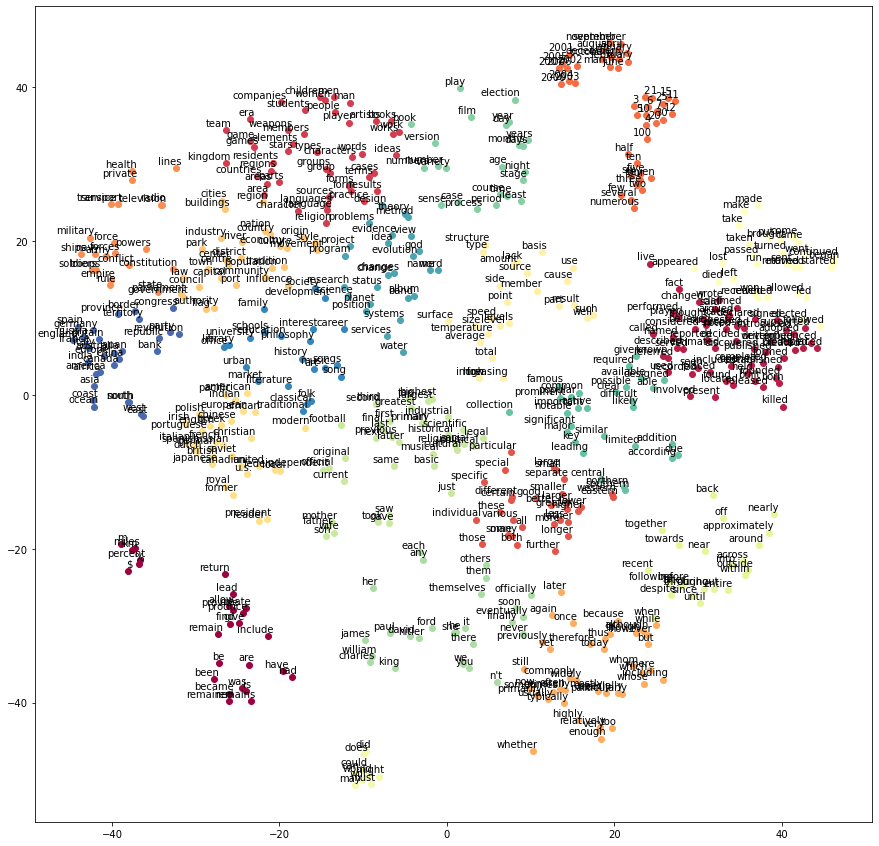

In [34]:
def plot(embeddings, labels):
  
    n_clusters = 20 # number of clusters
    # automatically build a discrete set of colors, each for cluster
    label_colors = [pylab.cm.Spectral(float(i) /n_clusters) for i in range(n_clusters)]
  
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  
    # Define K-Means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(embeddings)
    kmeans_labels = kmeans.labels_
  
    pylab.figure(figsize=(15,15))  # in inches
    
    # plot all the embeddings and their corresponding words
    for i, (label,klabel) in enumerate(zip(labels,kmeans_labels)):
        x, y = embeddings[i,:]
        pylab.scatter(x, y, c=label_colors[klabel])    

        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom',fontsize=10)

    # use for saving the figure if needed
    #pylab.savefig('word_embeddings.png')
    pylab.show()

words = [reverse_dictionary[i] for i in selected_ids]
plot(two_d_embeddings, words)
